In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../")

In [36]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torchsummary import summary

from data.input_transforms import InputTransform
from data.cifar import CIFAR
from data.stl import STL, LABEL_MAP
from data.dataloader import get_dataloader
from models.optimizer import optimizer, scheduler
from networks.twolayernet import TwolayerNet
from networks.convnet import ConvNet
from utils.viz import plot_multiple_quantities_by_time
from main import train, evaluate

### Load dataset

In [4]:
valid_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Resize",
        "args": {"size": 32},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]
valid_transform = InputTransform(valid_transforms)
valid_dataset = STL(root="../datasets/STL-10/", mode="valid", transform=valid_transform)
valid_loader = get_dataloader(valid_dataset, train=False, batch_size=128, num_workers=0)

:::: Loaded dataset from ../datasets/STL-10/: X ((500, 96, 96, 3)) y (500)


### Load model

In [5]:
# test checkpoint loading
net = ConvNet(
    in_channels=3,
    num_classes=5,
    ckpt_path="../checkpoints/cnn_best_hparams.pt",
    return_features=True,
)

### Visualize features without finetuning

In [6]:
net = net.eval()

In [14]:
val_features = []
valid_labels = []

iterator = tqdm(valid_loader, f"Extracting features", bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}')
with torch.no_grad():
    for i, batch in enumerate(iterator):
        images, targets = batch
        output = net(images)
        val_features.append(output.numpy())
        valid_labels.append(targets.numpy())

Extracting features: 100%|██████████████████████████████| 4/4 [00:00<00:00, 60.79it/s]                                                     


In [19]:
valid_features = np.vstack(val_features)
valid_labels = np.concatenate(valid_labels)

In [20]:
valid_features.shape, valid_labels.shape

((500, 400), (500,))

### Visualize features

In [21]:
X = valid_features
y = valid_labels

In [11]:
X = valid_features

f = TSNE(n_components=2)
Z = f.fit_transform(X)

In [12]:
Z.shape

(500, 2)

In [50]:
def visualize_features(
        X, y,
        title="Sample features",
        seed=0,
        save=False,
        save_path="../results/sample.png",
        show=True,
    ):
    np.random.seed(seed)

    tsne = TSNE(n_components=2, random_state=seed)
    Z = tsne.fit_transform(X)

    df = pd.DataFrame(None, columns=["Z1", "Z2", "label"])
    df["Z1"] = Z[:, 0]
    df["Z2"] = Z[:, 1]
    df["label"] = [LABEL_MAP[a].capitalize() for a in y]

    fig, ax = plt.subplots(1, 1, figsize=(11, 7))
    ax.grid()
    sns.scatterplot(
        data=df,
        x="Z1", y="Z2", hue="label", palette="Set2", legend=True, ax=ax, s=100,
    )
    ax.set_title(title, fontsize=17)
    
    plt.legend(fontsize=14)

    if save:
        plt.savefig(save_path, bbox_inches="tight")
    
    if save:
        plt.show()

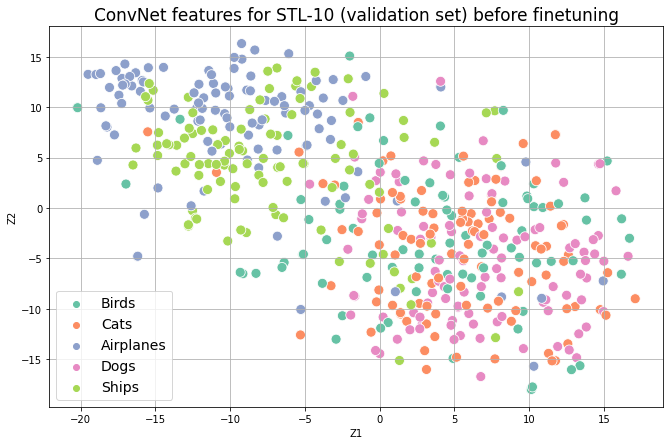

In [51]:
visualize_features(
    X, y,
    title="ConvNet features for STL-10 (validation set) before finetuning",
    save_path="../results/convnet_features_before_finetuning.png", save=True,
)

In [ ]:
def experiment(train_transforms, valid_transforms, network, num_epochs, batch_size, opt_args, sch_args=None):
    
    print(train_transforms)
    print(num_epochs)
    print(batch_size)
    print(opt_args)
    print(sch_args)
    
    # define the datasets
    train_transform = InputTransform(train_transforms)
    valid_transform = InputTransform(valid_transforms)
    train_dataset = CIFAR(root="../datasets/CIFAR-10/", mode="train", transform=train_transform)
    valid_dataset = CIFAR(root="../datasets/CIFAR-10/", mode="valid", transform=valid_transform)

    # obtain the train dataloader
    train_loader = get_dataloader(train_dataset, train=True, batch_size=batch_size, num_workers=0)
    valid_loader = get_dataloader(valid_dataset, train=False, batch_size=batch_size, num_workers=0)
    
    if network == "tln":
        net = TwolayerNet(num_inputs=3 * 32 * 32, num_hidden=512, num_classes=10)
    elif network == "cnn":
        net = ConvNet(in_channels=3, num_classes=10)
    else:
        raise ValueError()
    arch = type(net).__name__

    # define the optimizer and scheduler
    opt = optimizer(model_params=net.parameters(), **opt_args)
    sch = None
    if sch_args is not None:
        sch = scheduler(opt=opt, **sch_args)

    # define the loss function
    loss_fn = nn.CrossEntropyLoss()

    # train the model
    epochs, train_losses, train_metrics, valid_losses, valid_metrics = train(
        net, loss_fn, train_loader, valid_loader, num_epochs=num_epochs, opt=opt, sch=sch,
    )

    # plot training curves
    plot_multiple_quantities_by_time(
        quantities=[train_losses["loss"], valid_losses["loss"]],
        time=epochs,
        labels=["Train", "Validation"],
        title=f"{arch} Loss curves",
        show=True,
        save=True,
        save_path="../results/cnn_loss_plot_best.png",
        ylabel="Loss",
    )
    plot_multiple_quantities_by_time(
        quantities=[train_metrics["accuracy"], valid_metrics["accuracy"]],
        time=epochs,
        labels=["Train", "Validation"],
        title=f"{arch} Accuracy curves",
        show=True,
        save=True,
        save_path="../results/cnn_accu_plot_best.png",
        ylabel="Accuracy",
    )
    
    return net, loss_fn

[{'name': 'ToTensor', 'args': {}}, {'name': 'Normalize', 'args': {'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5)}}, {'name': 'RandomAffine', 'args': {'degrees': 10, 'translate': (0.1, 0.1), 'scale': (0.8, 1.2)}}]
100
128
{'name': 'Adam', 'lr': 0.001}
{'name': 'MultiStepLR', 'milestones': [50], 'gamma': 0.1}
Selecting 40000 for train.
Selecting 10000 for valid.


Evaluate: Epoch [1/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 115.61it/s]                                              


VALID 	: Summary: Loss: 1.6925 Accuracy: 0.3817
TRAIN 	: Summary: Loss: 1.9289 Accuracy: 0.2925


Evaluate: Epoch [2/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 111.43it/s]                                              


VALID 	: Summary: Loss: 1.5297 Accuracy: 0.4442
TRAIN 	: Summary: Loss: 1.6867 Accuracy: 0.3843


Evaluate: Epoch [3/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 124.71it/s]                                              


VALID 	: Summary: Loss: 1.4317 Accuracy: 0.4852
TRAIN 	: Summary: Loss: 1.5723 Accuracy: 0.4274


Evaluate: Epoch [4/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 127.22it/s]                                              


VALID 	: Summary: Loss: 1.3653 Accuracy: 0.5076
TRAIN 	: Summary: Loss: 1.5005 Accuracy: 0.4570


Evaluate: Epoch [5/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 125.03it/s]                                              


VALID 	: Summary: Loss: 1.3216 Accuracy: 0.5220
TRAIN 	: Summary: Loss: 1.4524 Accuracy: 0.4744


Evaluate: Epoch [6/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 112.68it/s]                                              


VALID 	: Summary: Loss: 1.2748 Accuracy: 0.5399
TRAIN 	: Summary: Loss: 1.4186 Accuracy: 0.4906


Evaluate: Epoch [7/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 123.84it/s]                                              


VALID 	: Summary: Loss: 1.2459 Accuracy: 0.5540
TRAIN 	: Summary: Loss: 1.3800 Accuracy: 0.5030


Evaluate: Epoch [8/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 111.79it/s]                                              


VALID 	: Summary: Loss: 1.2407 Accuracy: 0.5462
TRAIN 	: Summary: Loss: 1.3507 Accuracy: 0.5130


Evaluate: Epoch [9/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 126.14it/s]                                              


VALID 	: Summary: Loss: 1.1965 Accuracy: 0.5711
TRAIN 	: Summary: Loss: 1.3201 Accuracy: 0.5258


Evaluate: Epoch [10/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 128.06it/s]                                             


VALID 	: Summary: Loss: 1.1709 Accuracy: 0.5820
TRAIN 	: Summary: Loss: 1.2930 Accuracy: 0.5376


Evaluate: Epoch [11/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 122.65it/s]                                             


VALID 	: Summary: Loss: 1.1792 Accuracy: 0.5693
TRAIN 	: Summary: Loss: 1.2755 Accuracy: 0.5437


Evaluate: Epoch [12/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 124.06it/s]                                             


VALID 	: Summary: Loss: 1.1512 Accuracy: 0.5890
TRAIN 	: Summary: Loss: 1.2532 Accuracy: 0.5519


Evaluate: Epoch [13/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 117.27it/s]                                             


VALID 	: Summary: Loss: 1.1154 Accuracy: 0.5995
TRAIN 	: Summary: Loss: 1.2398 Accuracy: 0.5597


Evaluate: Epoch [14/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 123.84it/s]                                             


VALID 	: Summary: Loss: 1.1332 Accuracy: 0.5944
TRAIN 	: Summary: Loss: 1.2283 Accuracy: 0.5618


Evaluate: Epoch [15/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 124.32it/s]                                             


VALID 	: Summary: Loss: 1.1046 Accuracy: 0.6043
TRAIN 	: Summary: Loss: 1.2160 Accuracy: 0.5638


Evaluate: Epoch [16/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 125.65it/s]                                             


VALID 	: Summary: Loss: 1.1169 Accuracy: 0.6071
TRAIN 	: Summary: Loss: 1.1983 Accuracy: 0.5736


Evaluate: Epoch [17/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 122.21it/s]                                             


VALID 	: Summary: Loss: 1.0852 Accuracy: 0.6109
TRAIN 	: Summary: Loss: 1.1912 Accuracy: 0.5736


Evaluate: Epoch [18/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 127.72it/s]                                             


VALID 	: Summary: Loss: 1.0859 Accuracy: 0.6153
TRAIN 	: Summary: Loss: 1.1725 Accuracy: 0.5835


Evaluate: Epoch [19/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 125.42it/s]                                             


VALID 	: Summary: Loss: 1.0813 Accuracy: 0.6152
TRAIN 	: Summary: Loss: 1.1676 Accuracy: 0.5834


Evaluate: Epoch [20/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 122.04it/s]                                             


VALID 	: Summary: Loss: 1.0852 Accuracy: 0.6161
TRAIN 	: Summary: Loss: 1.1566 Accuracy: 0.5877


Evaluate: Epoch [21/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 123.06it/s]                                             


VALID 	: Summary: Loss: 1.0670 Accuracy: 0.6241
TRAIN 	: Summary: Loss: 1.1564 Accuracy: 0.5884


Evaluate: Epoch [22/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 111.02it/s]                                             


VALID 	: Summary: Loss: 1.0563 Accuracy: 0.6282
TRAIN 	: Summary: Loss: 1.1395 Accuracy: 0.5955


Evaluate: Epoch [23/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 127.72it/s]                                             


VALID 	: Summary: Loss: 1.0384 Accuracy: 0.6322
TRAIN 	: Summary: Loss: 1.1314 Accuracy: 0.5997


Evaluate: Epoch [24/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 126.35it/s]                                             


VALID 	: Summary: Loss: 1.0621 Accuracy: 0.6210
TRAIN 	: Summary: Loss: 1.1222 Accuracy: 0.6021


Evaluate: Epoch [25/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 123.42it/s]                                             


VALID 	: Summary: Loss: 1.0259 Accuracy: 0.6372
TRAIN 	: Summary: Loss: 1.1101 Accuracy: 0.6026


Evaluate: Epoch [26/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 128.50it/s]                                             


VALID 	: Summary: Loss: 1.0468 Accuracy: 0.6260
TRAIN 	: Summary: Loss: 1.1106 Accuracy: 0.6066


Evaluate: Epoch [27/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 127.76it/s]                                             


VALID 	: Summary: Loss: 1.0198 Accuracy: 0.6371
TRAIN 	: Summary: Loss: 1.1009 Accuracy: 0.6082


Evaluate: Epoch [28/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 123.41it/s]                                             


VALID 	: Summary: Loss: 1.0600 Accuracy: 0.6210
TRAIN 	: Summary: Loss: 1.0972 Accuracy: 0.6093


Evaluate: Epoch [29/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 129.96it/s]                                             


VALID 	: Summary: Loss: 1.0303 Accuracy: 0.6315
TRAIN 	: Summary: Loss: 1.0943 Accuracy: 0.6112


Evaluate: Epoch [30/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 123.83it/s]                                             


VALID 	: Summary: Loss: 1.0106 Accuracy: 0.6411
TRAIN 	: Summary: Loss: 1.0815 Accuracy: 0.6155


Evaluate: Epoch [31/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 126.35it/s]                                             


VALID 	: Summary: Loss: 1.0023 Accuracy: 0.6422
TRAIN 	: Summary: Loss: 1.0713 Accuracy: 0.6173


Evaluate: Epoch [32/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 124.17it/s]                                             


VALID 	: Summary: Loss: 0.9983 Accuracy: 0.6480
TRAIN 	: Summary: Loss: 1.0724 Accuracy: 0.6190


Evaluate: Epoch [33/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 125.23it/s]                                             


VALID 	: Summary: Loss: 1.0230 Accuracy: 0.6374
TRAIN 	: Summary: Loss: 1.0650 Accuracy: 0.6238


Evaluate: Epoch [34/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 121.10it/s]                                             


VALID 	: Summary: Loss: 1.0065 Accuracy: 0.6439
TRAIN 	: Summary: Loss: 1.0555 Accuracy: 0.6248


Evaluate: Epoch [35/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 126.78it/s]                                             


VALID 	: Summary: Loss: 0.9977 Accuracy: 0.6464
TRAIN 	: Summary: Loss: 1.0524 Accuracy: 0.6244


Evaluate: Epoch [36/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 127.14it/s]                                             


VALID 	: Summary: Loss: 0.9898 Accuracy: 0.6482
TRAIN 	: Summary: Loss: 1.0522 Accuracy: 0.6278


Evaluate: Epoch [37/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 126.35it/s]                                             


VALID 	: Summary: Loss: 0.9818 Accuracy: 0.6518
TRAIN 	: Summary: Loss: 1.0434 Accuracy: 0.6312


Evaluate: Epoch [38/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 126.19it/s]                                             


VALID 	: Summary: Loss: 0.9860 Accuracy: 0.6484
TRAIN 	: Summary: Loss: 1.0454 Accuracy: 0.6297


Evaluate: Epoch [39/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 126.49it/s]                                             


VALID 	: Summary: Loss: 1.0100 Accuracy: 0.6441
TRAIN 	: Summary: Loss: 1.0398 Accuracy: 0.6295


Evaluate: Epoch [40/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 111.94it/s]                                             


VALID 	: Summary: Loss: 0.9742 Accuracy: 0.6607
TRAIN 	: Summary: Loss: 1.0412 Accuracy: 0.6295


Evaluate: Epoch [41/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 92.81it/s]                                              


VALID 	: Summary: Loss: 0.9653 Accuracy: 0.6598
TRAIN 	: Summary: Loss: 1.0301 Accuracy: 0.6343


Evaluate: Epoch [42/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 121.10it/s]                                             


VALID 	: Summary: Loss: 0.9810 Accuracy: 0.6519
TRAIN 	: Summary: Loss: 1.0257 Accuracy: 0.6367


Evaluate: Epoch [43/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 123.55it/s]                                             


VALID 	: Summary: Loss: 0.9864 Accuracy: 0.6511
TRAIN 	: Summary: Loss: 1.0167 Accuracy: 0.6363


Evaluate: Epoch [44/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 120.07it/s]                                             


VALID 	: Summary: Loss: 0.9742 Accuracy: 0.6563
TRAIN 	: Summary: Loss: 1.0173 Accuracy: 0.6360


Evaluate: Epoch [45/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 123.33it/s]                                             


VALID 	: Summary: Loss: 0.9690 Accuracy: 0.6552
TRAIN 	: Summary: Loss: 1.0095 Accuracy: 0.6406


Evaluate: Epoch [46/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 122.20it/s]                                             


VALID 	: Summary: Loss: 0.9637 Accuracy: 0.6604
TRAIN 	: Summary: Loss: 1.0131 Accuracy: 0.6398


Evaluate: Epoch [47/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 118.87it/s]                                             


VALID 	: Summary: Loss: 0.9767 Accuracy: 0.6512
TRAIN 	: Summary: Loss: 1.0117 Accuracy: 0.6414


Evaluate: Epoch [48/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 124.80it/s]                                             


VALID 	: Summary: Loss: 0.9578 Accuracy: 0.6645
TRAIN 	: Summary: Loss: 1.0091 Accuracy: 0.6417


Evaluate: Epoch [49/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 123.62it/s]                                             


VALID 	: Summary: Loss: 0.9668 Accuracy: 0.6547
TRAIN 	: Summary: Loss: 1.0023 Accuracy: 0.6439


Evaluate: Epoch [50/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 128.31it/s]                                             


VALID 	: Summary: Loss: 0.9604 Accuracy: 0.6630
TRAIN 	: Summary: Loss: 1.0011 Accuracy: 0.6450


Evaluate: Epoch [51/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 96.71it/s]                                              


VALID 	: Summary: Loss: 0.9212 Accuracy: 0.6757
TRAIN 	: Summary: Loss: 0.9531 Accuracy: 0.6623


Evaluate: Epoch [52/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 122.29it/s]                                             


VALID 	: Summary: Loss: 0.9207 Accuracy: 0.6764
TRAIN 	: Summary: Loss: 0.9412 Accuracy: 0.6670


Evaluate: Epoch [53/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 97.88it/s]                                              


VALID 	: Summary: Loss: 0.9198 Accuracy: 0.6747
TRAIN 	: Summary: Loss: 0.9415 Accuracy: 0.6649


Evaluate: Epoch [54/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 124.73it/s]                                             


VALID 	: Summary: Loss: 0.9177 Accuracy: 0.6766
TRAIN 	: Summary: Loss: 0.9363 Accuracy: 0.6659


Evaluate: Epoch [55/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 125.87it/s]                                             


VALID 	: Summary: Loss: 0.9207 Accuracy: 0.6727
TRAIN 	: Summary: Loss: 0.9371 Accuracy: 0.6680


Evaluate: Epoch [56/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 126.07it/s]                                             


VALID 	: Summary: Loss: 0.9179 Accuracy: 0.6762
TRAIN 	: Summary: Loss: 0.9363 Accuracy: 0.6687


Evaluate: Epoch [57/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 120.93it/s]                                             


VALID 	: Summary: Loss: 0.9164 Accuracy: 0.6762
TRAIN 	: Summary: Loss: 0.9316 Accuracy: 0.6715


Evaluate: Epoch [58/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 118.00it/s]                                             


VALID 	: Summary: Loss: 0.9140 Accuracy: 0.6763
TRAIN 	: Summary: Loss: 0.9310 Accuracy: 0.6714


Evaluate: Epoch [59/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 121.22it/s]                                             


VALID 	: Summary: Loss: 0.9166 Accuracy: 0.6746
TRAIN 	: Summary: Loss: 0.9292 Accuracy: 0.6710


Evaluate: Epoch [60/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 123.75it/s]                                             


VALID 	: Summary: Loss: 0.9133 Accuracy: 0.6770
TRAIN 	: Summary: Loss: 0.9316 Accuracy: 0.6727


Evaluate: Epoch [61/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 124.36it/s]                                             


VALID 	: Summary: Loss: 0.9178 Accuracy: 0.6779
TRAIN 	: Summary: Loss: 0.9330 Accuracy: 0.6703


Evaluate: Epoch [62/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 126.46it/s]                                             


VALID 	: Summary: Loss: 0.9150 Accuracy: 0.6774
TRAIN 	: Summary: Loss: 0.9283 Accuracy: 0.6715


Evaluate: Epoch [63/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 113.47it/s]                                             


VALID 	: Summary: Loss: 0.9159 Accuracy: 0.6746
TRAIN 	: Summary: Loss: 0.9298 Accuracy: 0.6728


Evaluate: Epoch [64/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 95.87it/s]                                              


VALID 	: Summary: Loss: 0.9135 Accuracy: 0.6768
TRAIN 	: Summary: Loss: 0.9295 Accuracy: 0.6688


Evaluate: Epoch [65/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 124.60it/s]                                             


VALID 	: Summary: Loss: 0.9149 Accuracy: 0.6796
TRAIN 	: Summary: Loss: 0.9237 Accuracy: 0.6730


Evaluate: Epoch [66/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 126.50it/s]                                             


VALID 	: Summary: Loss: 0.9145 Accuracy: 0.6786
TRAIN 	: Summary: Loss: 0.9229 Accuracy: 0.6724


Evaluate: Epoch [67/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 123.21it/s]                                             


VALID 	: Summary: Loss: 0.9131 Accuracy: 0.6775
TRAIN 	: Summary: Loss: 0.9260 Accuracy: 0.6725


Evaluate: Epoch [68/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 126.80it/s]                                             


VALID 	: Summary: Loss: 0.9167 Accuracy: 0.6767
TRAIN 	: Summary: Loss: 0.9236 Accuracy: 0.6718


Evaluate: Epoch [69/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 122.84it/s]                                             


VALID 	: Summary: Loss: 0.9168 Accuracy: 0.6772
TRAIN 	: Summary: Loss: 0.9232 Accuracy: 0.6717


Evaluate: Epoch [70/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 124.63it/s]                                             


VALID 	: Summary: Loss: 0.9143 Accuracy: 0.6782
TRAIN 	: Summary: Loss: 0.9201 Accuracy: 0.6717


Evaluate: Epoch [71/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 120.91it/s]                                             


VALID 	: Summary: Loss: 0.9152 Accuracy: 0.6776
TRAIN 	: Summary: Loss: 0.9213 Accuracy: 0.6729


Evaluate: Epoch [72/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 123.32it/s]                                             


VALID 	: Summary: Loss: 0.9146 Accuracy: 0.6776
TRAIN 	: Summary: Loss: 0.9250 Accuracy: 0.6726


Evaluate: Epoch [73/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 115.53it/s]                                             


VALID 	: Summary: Loss: 0.9113 Accuracy: 0.6773
TRAIN 	: Summary: Loss: 0.9198 Accuracy: 0.6730


Evaluate: Epoch [74/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 114.00it/s]                                             


VALID 	: Summary: Loss: 0.9124 Accuracy: 0.6784
TRAIN 	: Summary: Loss: 0.9264 Accuracy: 0.6701


Evaluate: Epoch [75/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 91.41it/s]                                              


VALID 	: Summary: Loss: 0.9118 Accuracy: 0.6788
TRAIN 	: Summary: Loss: 0.9244 Accuracy: 0.6717


Evaluate: Epoch [76/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 124.08it/s]                                             


VALID 	: Summary: Loss: 0.9148 Accuracy: 0.6783
TRAIN 	: Summary: Loss: 0.9203 Accuracy: 0.6737


Evaluate: Epoch [77/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 119.03it/s]                                             


VALID 	: Summary: Loss: 0.9146 Accuracy: 0.6754
TRAIN 	: Summary: Loss: 0.9196 Accuracy: 0.6757


Evaluate: Epoch [78/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 121.53it/s]                                             


VALID 	: Summary: Loss: 0.9125 Accuracy: 0.6766
TRAIN 	: Summary: Loss: 0.9168 Accuracy: 0.6763


Evaluate: Epoch [79/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 121.50it/s]                                             


VALID 	: Summary: Loss: 0.9163 Accuracy: 0.6771
TRAIN 	: Summary: Loss: 0.9196 Accuracy: 0.6724


Evaluate: Epoch [80/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 125.65it/s]                                             


VALID 	: Summary: Loss: 0.9116 Accuracy: 0.6795
TRAIN 	: Summary: Loss: 0.9201 Accuracy: 0.6738


Evaluate: Epoch [81/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 125.72it/s]                                             


VALID 	: Summary: Loss: 0.9118 Accuracy: 0.6790
TRAIN 	: Summary: Loss: 0.9224 Accuracy: 0.6760


Evaluate: Epoch [82/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 122.77it/s]                                             


VALID 	: Summary: Loss: 0.9163 Accuracy: 0.6757
TRAIN 	: Summary: Loss: 0.9197 Accuracy: 0.6753


Evaluate: Epoch [83/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 119.64it/s]                                             


VALID 	: Summary: Loss: 0.9137 Accuracy: 0.6792
TRAIN 	: Summary: Loss: 0.9172 Accuracy: 0.6750


Evaluate: Epoch [84/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 113.54it/s]                                             


VALID 	: Summary: Loss: 0.9123 Accuracy: 0.6785
TRAIN 	: Summary: Loss: 0.9194 Accuracy: 0.6760


Evaluate: Epoch [85/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 122.36it/s]                                             


VALID 	: Summary: Loss: 0.9124 Accuracy: 0.6782
TRAIN 	: Summary: Loss: 0.9175 Accuracy: 0.6751


Evaluate: Epoch [86/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 124.61it/s]                                             


VALID 	: Summary: Loss: 0.9120 Accuracy: 0.6807
TRAIN 	: Summary: Loss: 0.9126 Accuracy: 0.6781


Evaluate: Epoch [87/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 118.49it/s]                                             


VALID 	: Summary: Loss: 0.9110 Accuracy: 0.6776
TRAIN 	: Summary: Loss: 0.9140 Accuracy: 0.6757


Evaluate: Epoch [88/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 125.10it/s]                                             


VALID 	: Summary: Loss: 0.9134 Accuracy: 0.6783
TRAIN 	: Summary: Loss: 0.9105 Accuracy: 0.6785


Evaluate: Epoch [89/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 113.93it/s]                                             


VALID 	: Summary: Loss: 0.9116 Accuracy: 0.6794
TRAIN 	: Summary: Loss: 0.9179 Accuracy: 0.6727


Evaluate: Epoch [90/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 126.48it/s]                                             


VALID 	: Summary: Loss: 0.9088 Accuracy: 0.6798
TRAIN 	: Summary: Loss: 0.9182 Accuracy: 0.6748


Evaluate: Epoch [91/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 122.56it/s]                                             


VALID 	: Summary: Loss: 0.9089 Accuracy: 0.6777
TRAIN 	: Summary: Loss: 0.9123 Accuracy: 0.6771


Evaluate: Epoch [92/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 125.70it/s]                                             


VALID 	: Summary: Loss: 0.9122 Accuracy: 0.6796
TRAIN 	: Summary: Loss: 0.9123 Accuracy: 0.6767


Evaluate: Epoch [93/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 122.49it/s]                                             


VALID 	: Summary: Loss: 0.9058 Accuracy: 0.6808
TRAIN 	: Summary: Loss: 0.9082 Accuracy: 0.6783


Evaluate: Epoch [94/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 124.87it/s]                                             


VALID 	: Summary: Loss: 0.9148 Accuracy: 0.6774
TRAIN 	: Summary: Loss: 0.9081 Accuracy: 0.6784


Evaluate: Epoch [95/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 117.05it/s]                                             


VALID 	: Summary: Loss: 0.9132 Accuracy: 0.6778
TRAIN 	: Summary: Loss: 0.9164 Accuracy: 0.6777


Evaluate: Epoch [96/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 118.53it/s]                                             


VALID 	: Summary: Loss: 0.9094 Accuracy: 0.6793
TRAIN 	: Summary: Loss: 0.9117 Accuracy: 0.6760


Evaluate: Epoch [97/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 121.44it/s]                                             


VALID 	: Summary: Loss: 0.9087 Accuracy: 0.6794
TRAIN 	: Summary: Loss: 0.9074 Accuracy: 0.6770


Evaluate: Epoch [98/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 118.88it/s]                                             


VALID 	: Summary: Loss: 0.9076 Accuracy: 0.6802
TRAIN 	: Summary: Loss: 0.9061 Accuracy: 0.6812


Evaluate: Epoch [99/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 125.56it/s]                                             


VALID 	: Summary: Loss: 0.9100 Accuracy: 0.6796
TRAIN 	: Summary: Loss: 0.9093 Accuracy: 0.6796


Evaluate: Epoch [100/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 127.17it/s]                                            


VALID 	: Summary: Loss: 0.9078 Accuracy: 0.6812
TRAIN 	: Summary: Loss: 0.9065 Accuracy: 0.6802


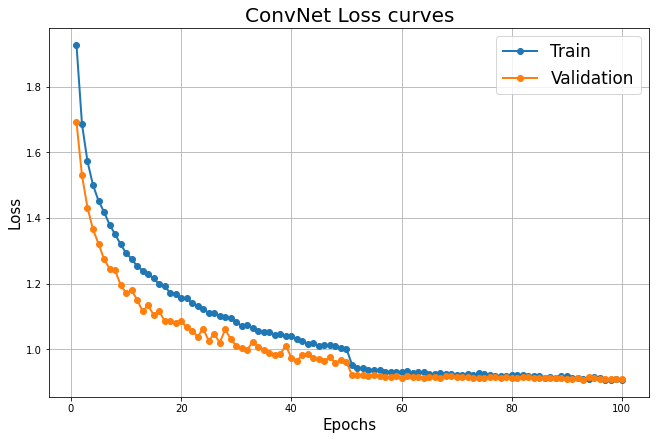

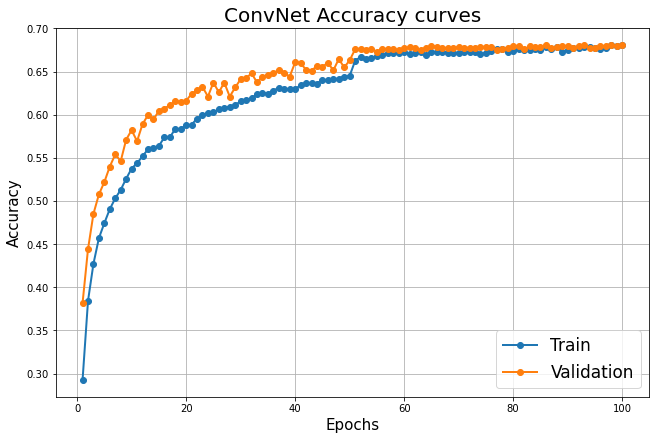

In [ ]:
train_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
    {
        "name": "RandomAffine",
        "args": {"degrees": 10, "translate": (0.1, 0.1), "scale": (0.8, 1.2)},
    },
]
valid_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]

network = "cnn"
num_epochs = 100
batch_size = 128
opt_args = {"name": "Adam", "lr": 1e-3}

sch_args = None
sch_args = {"name": "MultiStepLR", "milestones": [50], "gamma": 0.1}

net, loss_fn = experiment(
    train_transforms, valid_transforms, network, num_epochs, batch_size, opt_args, sch_args=sch_args,
)

In [ ]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [ ]:
test_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]
test_transform = InputTransform(test_transforms)
test_dataset = CIFAR(root="../datasets/CIFAR-10/", mode="test", transform=test_transform)
test_loader = get_dataloader(test_dataset, train=False, batch_size=128, num_workers=0)

In [8]:
evaluate(net, test_loader, loss_fn, 1, 1, "test")

Evaluate: Epoch [1/1]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 128.76it/s]                                                

TEST 	: Summary: Loss: 0.9494 Accuracy: 0.6716


(0.9494288541093657, 0.6716)

In [12]:
torch.save(net, "../checkpoints/cnn_best_hparams.pt")